# Unsupervised State-Inference
In reinforcement learning, it's often useful to assume that we can describe a problem in a discrete and finite set of states. For example, we might have an known number of independent bandits, or a grid-world with defined locations of objects. One reason this representation is useful is that it can dramtically simplify the problem of planning: given a known set of states $S$, a transition function $T(s,a,s') = p(s'|s,a)$ that defines the conditional probability of arriving in state $s'$ having taken action $a$ in state $s'$, and reward function $R(s, a, s')$ that defines the values over our state-action space, there are known polynomial time planning algorithms. 

In naturalistic enviornments, however, it can be difficult to translate raw perceptual stimuli into discrete states. Typically, states are an assumption of an enviornment and we often lack a principaled way to discover them from observation alone.  

Here, the goal is to discover states using an unsupervised learning algorithm.  We'll assume states are discrete, independent latent variables and use variational inference to learn conditional probability distribution over states. More formally, given a real-valued observation vector $x\in R^d$, we want to learn a paramterized function $f_\theta(x)$ that defines a probability distribution over states $s$. We'll assume that we don't have access to the states, but only have the observation tuples $(x, x')$ that define transitions an agent makes in an enviornment. We will use a discrete variaitional autoencoder (VAE) for our unsupervised algorithm.




In [1]:
# ### Comment out for local run
# !pip install git+https://github.com/nicktfranklin/value_iteration_network.git

In [2]:
# comment out for local run
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir(
    "/content/drive/Othercomputers/My MacBook Pro/Projects/ValueIteration"
    )
os.getcwd()

Mounted at /content/drive


'/content/drive/Othercomputers/My MacBook Pro/Projects/ValueIteration'

In [3]:
%matplotlib inline
from collections import namedtuple
from random import choices
from typing import Callable, Dict, Hashable, List, Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
# from scipy.signal import fftconvolve
from sklearn.metrics import pairwise_distances
from torch.distributions.categorical import Categorical
from torch.utils.data import Dataset

In [4]:
from environments.state_inference import ObservationModel, TransitionModel, RewardModel
from environments.state_inference import make_cardinal_transition_function, value_iteration

In [5]:
import sys
print(f"python {sys.version}")
print(f"torch {torch.__version__}")

python 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
torch 2.0.0+cu118


## Toy World
First, it's useful to construct a toy world and the stimuli we'll need for the model. I'm making the assumption that the underlying MDP is a $n\times n$ grid-world that's embedded in much higher dimensional observational space. To do so, I'll construct a much larger grid with dimensions $m\times m$, where $m > n$, and evenly space the states in the grid. I then add a couple of sources of noise and convole the observations with a Gaussian kernel to generate the observations.  This increases the dimensionality substantially (going from $n^2$ to $m^2$) and adds significant overlap between the observations.

We can think of these observations as a toy model for soemthing like a robot's estimate of it's position, or a perhaps as a model of hippocampal grid cells.  Importantly, this doesn't have to be exclusively a spatial model -- none of the subsequent modeling uses visual inductive biases and I'm hopeful this is more general toy model.

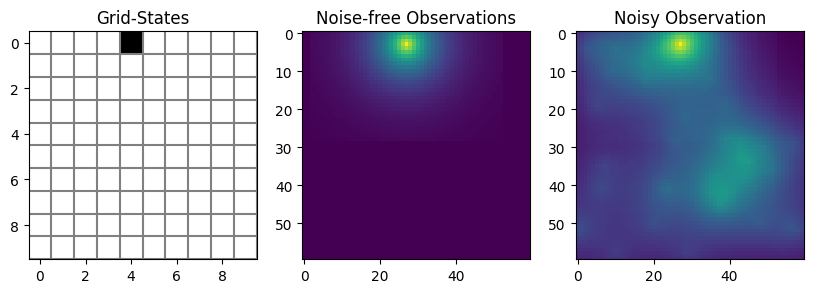

In [6]:
# Discritized states: a 10x10 grid of states, which we embed by spacing 
# evenly in a nXn space
h, w = 10, 10
map_height = 60


gw_kwargs = dict(
    rbf_kernel_size = 51, # must be odd
    rbf_kernel_scale = .15,
    location_noise_scale = 1.0
)

        
observation_model = ObservationModel(h, w, map_height, **gw_kwargs)
        


# show an example location
s = 4
x, y = observation_model.get_obs_coords(s)
raw_state = observation_model.get_grid_location(s)
fig, axes = plt.subplots(1, 3, figsize=(10, 20))
axes[0].imshow(1 - raw_state, cmap='gray')
def plt_lines(h, w, ax):
  y_lim = ax.get_ylim()
  x_lim = ax.get_xlim()
  for h0 in range(h):
    ax.plot([h0+0.5, h0+0.5], [-0.5, w+0.5], c='gray')
  for w0 in range(w):
    ax.plot([-0.5, h+0.5], [w0+0.5, w0+0.5], c='gray')
  ax.set_ylim(y_lim)
  ax.set_xlim(x_lim)
plt_lines(h,w, axes[0])
axes[1].imshow(observation_model.embed_state(s))
axes[2].imshow(observation_model.embed_state_corrupted(s))
axes[0].set_title('Grid-States')
axes[1].set_title('Noise-free Observations')
axes[2].set_title('Noisy Observation')
plt.show()

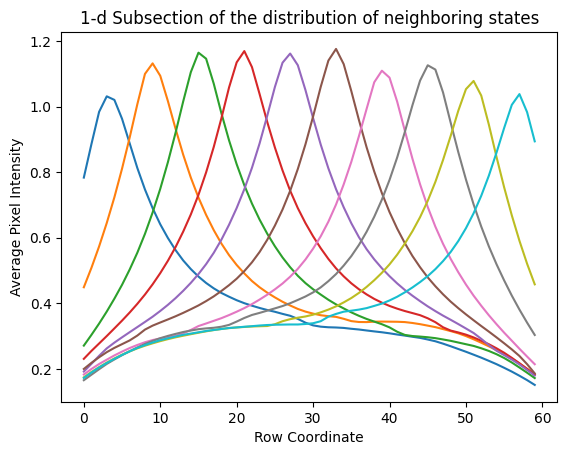

In [7]:
## show the 1-d overlap of neighboring states
x, _ = observation_model.get_obs_coords(26)

[plt.plot(np.mean([observation_model.embed_state_corrupted(s)[x, :] for _ in range(100)], axis=0))
for s in range(20, 30)]

plt.xlabel('Row Coordinate')
plt.ylabel('Average Pixel Intensity')
plt.title('1-d Subsection of the distribution of neighboring states')
plt.show()


Notably, there is a overlap in our observation space. We can control this overlap parametrically by changing the length scale of our convolution kernel (this is akin to a wider belief distribution)

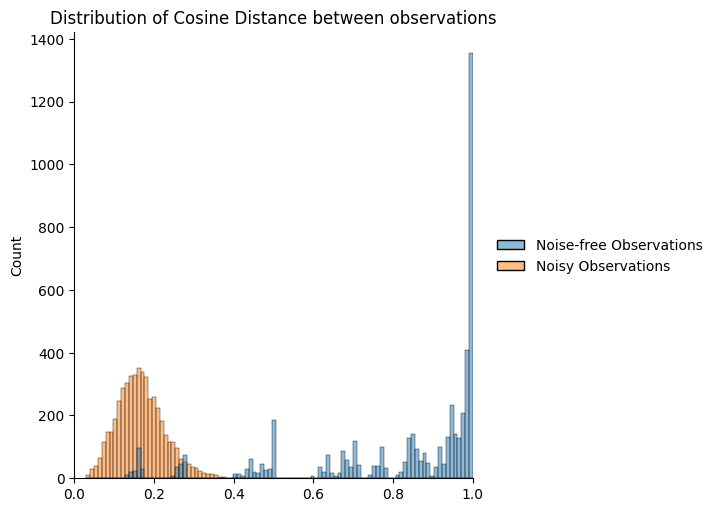

In [8]:
def pairwise_embedding_distances(observation_model, corrupt=False):
    def embed(s):
        if corrupt:
            return observation_model.embed_state_corrupted(s).reshape(-1) 
        return observation_model.embed_state(s).reshape(-1) 
    
    sample_embeddings = {
        s: embed(s)
        for s in observation_model.states.keys()
    }

    distances = pairwise_distances(
        np.array(list(sample_embeddings.values())), metric="cosine"
    )

    mask = np.tril(np.ones_like(distances, dtype=bool), k=-1)
    return distances.reshape(-1)[mask.reshape(-1)]

  

sns.displot(
   {
    'Noise-free Observations': pairwise_embedding_distances(
       observation_model, corrupt=False
       ),
#     'Noisy Observations': np.mean([pairwise_embedding_distances(
#        observation_model, corrupt=True
#        ) for _ in range(100)
#         ], axis=0),
    'Noisy Observations': pairwise_embedding_distances(
       observation_model, corrupt=True
       ),
   },
   bins=100
)

plt.title('Distribution of Cosine Distance between observations')
plt.xlim([0,1])
plt.show()

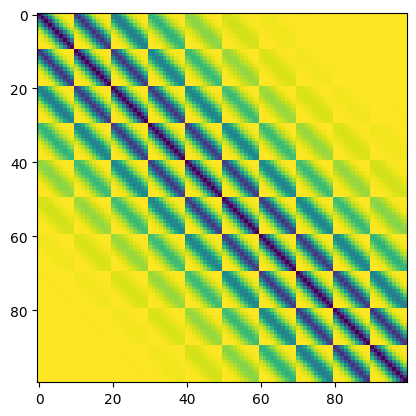

In [9]:
sample_embeddings = {}
for s in observation_model.states.keys():
    sample_embeddings[s] = observation_model.embed_state(s).reshape(-1)

noise_free_embedding_distances = pairwise_distances(
    np.array(list(sample_embeddings.values())), metric="cosine"
)
plt.imshow(
noise_free_embedding_distances)

### Random Walk 
Define a random walk over the grid-world and plot a sample trajectory

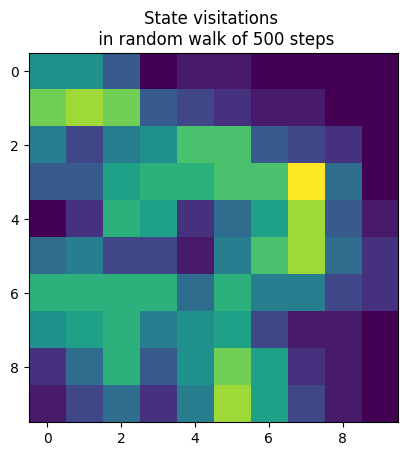

In [10]:
# Define a random walk between coordinate neighbors. 
# This is will be used to during training

def make_transitions(h, w):
    t = np.zeros((h * w, h * w))
    for s0 in range(h * w):

        # if s0 + 1

        if s0 - w >= 0:
            t[s0, s0 - w] = 1
        if s0 + w + 1 < h * w:
            t[s0, s0 + w] = 1

        if (s0 + 1) % w > 0:
            t[s0, s0 + 1] = 1

        if s0 % w > 0:
            t[s0, s0 - 1] = 1

    # normalize
    t /= np.tile(t.sum(axis=1).reshape(-1, 1), h * w)

    return t


grid_size = 10
ground_truth_transitions = make_transitions(grid_size,grid_size)

# derive the edges of the graph
edges = {}
for s, t in enumerate(ground_truth_transitions):
  edges[s] = np.where(t > 0)[0]
# print(edges)

# 
def generate_random_walk(walk_length, edges):
  random_walk = []
  s = choices(list(edges.keys()))[0]
  random_walk.append(s)
  state_counts = np.zeros(len(edges))
  for _ in range(walk_length):
    s = choices(edges[s])[0]
    state_counts[s] += 1
    random_walk.append(s)

  return state_counts, random_walk

n = 500
state_counts, walk = generate_random_walk(n, edges)
plt.imshow(state_counts.reshape(grid_size,grid_size))
plt.title(f'State visitations \n in random walk of {n} steps')
plt.show()

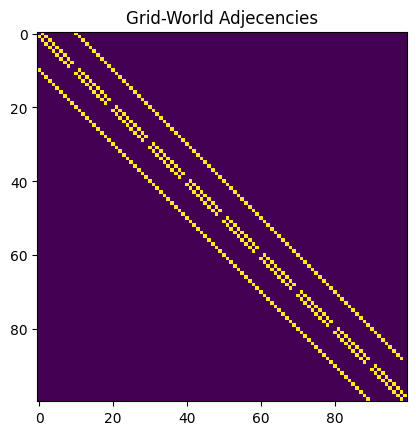

In [11]:
plt.imshow(ground_truth_transitions > 0)
plt.title('Grid-World Adjecencies')
plt.show()

## Discrete State-VAE
The core idea is to use a discrete Variational Autoencoder, where states are represented as one-hot vector embeddings. The VAE is an encoder/decoder model, where the encoder learns a parameterized probability distribution over embeddings and the decoder reconstructs the original input vector from the vector embedding. 

The model has three key components:
* An encoder model: $f_\theta(x) = \omega$
* A Gumbel-Sofmax probability distribution over states $p_\omega(z) \propto exp(\omega + \epsilon)$, where $ \epsilon$ is an external source of noise drawn from the Gumbel distribution.
* A decoder model: $d_\theta(z) = x$

The model is trained with stochastic variational gradient descent: an input is passed through the decoder, a state is sampled from the Gumbel-softmax distribution, and the input is reconstructed by the decoder. This forward pass is used to calculate the ELBO loss function:
$$ELBO(x) = \log q(x|z) - KL(q(z|x)||p(z))$$
where $\log q(x|z)$ is the reconstruction loss of the network and $KL(q(z|x)||p(z))$ is the KL diveregence of the learned embedding distribution and a prior over states. Under gentle assumptions, $-\log q(x|z)$ is the mean squared error of the reconstructed output relative to the input and the $KL(q(z|x)||p(z))$ becomes the entropy of the embedding distribution.




### Model
This is the code for the VAE

In [12]:

class MLP(nn.Module):
  def __init__(
      self, 
      input_size:int,
      hidden_sizes: list,
      output_size:int,
      dropout: float = 0.01,
      ):
    super().__init__()        
    self.nin = input_size
    self.nout = output_size

    # define a simple MLP neural net
    self.net = []
    hs = [self.nin] + hidden_sizes + [self.nout]
    for h0,h1 in zip(hs, hs[1:]):
        self.net.extend([
                nn.Linear(h0, h1),
                nn.BatchNorm1d(h1),
                nn.Dropout(p=dropout),
                nn.ReLU(),

            ])
    
    # pop the last ReLU and dropout layers for the output
    # self.net.pop()
    self.net.pop() 
    self.net.pop()

    self.net = nn.Sequential(*self.net)

  def forward(self, x):
    return self.net(x)


class mDVAE(nn.Module):
  def __init__(
      self, 
      encoder: nn.Module, 
      decoder: nn.Module, 
      z_dim:int, 
      z_layers: int = 2,
      beta: float = 1, 
      tau: float = 1,
      gamma: float = 1,
      random_encoder: bool = False):
    super().__init__()        
    self.encoder = encoder
    self.decoder = decoder
    self.z_layers = z_layers
    self.z_dim = z_dim
    self.beta = beta
    self.tau = tau
    self.gamma = gamma
    self.random_encoder = random_encoder

    if random_encoder:
      for child in self.encoder.children():
        for param in child.parameters():
          param.requires_grad = False

  def reparameterize(self, logits):
    # either sample the state or take the argmax
    if self.training:
      z = F.gumbel_softmax(logits=logits, tau=self.tau, hard=False)
    else:
      s = torch.argmax(logits, dim=-1) # tensor of n_batch * self.z_n_layers
      z = F.one_hot(s, num_classes=self.z_dim)
    return z

  def encode(self, x):
    # reshape encoder output to (n_batch, z_layers, z_dim)
    logits = self.encoder(x).view(-1, self.z_layers, self.z_dim)
    z = self.reparameterize(logits)
    return logits, z

  def decode(self, z):
    return self.decoder(z.view(-1, self.z_layers * self.z_dim).float())

  def forward(self, x):
    _, z = self.encode(x)
    return self.decode(z)

  def kl_loss(self, logits):
    return Categorical(logits=logits).entropy().mean()

  def reconstruction_loss(self, x, z):
    x_hat = self.decode(z)
    return F.mse_loss(x_hat, x)

  def loss(self, x):
    logits, z = self.encode(x)
    return self.loss_from_embedding(x, logits, z)

  def loss_from_embedding(self, x, logits, z):
    kl_loss = self.kl_loss(logits)
    recon_loss = self.reconstruction_loss(x, z)
    return recon_loss + kl_loss * self.beta
    
  def state_probability(self, x):
    with torch.no_grad():
      logits = self.encoder(x)
      return Categorical(logits=logits).probs

  def get_state(self, x):
    self.eval()
    _, z = self.encode(x)
    return torch.argmax(z, dim=-1)

  def decode_state(self, s: Tuple[int]):
    self.eval()
    z = F.one_hot(torch.tensor(s).to(DEVICE), self.z_dim).view(-1).unsqueeze(0)
    with torch.no_grad():
      return self.decode(z).detach().cpu().numpy()

  def anneal_tau(self):
    self.tau *= self.gamma
    


### Training Functions
Helper functions to train the model

In [13]:
# helper functions for training
QUIET = False
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(model, train_loader, optimizer, epoch, clip_grad = None):
  model.train()

  train_losses = []
  for x in train_loader:
    x = x.to(DEVICE).float()

    optimizer.zero_grad()
    loss = model.loss(x)
    loss.backward()

    if clip_grad:
      torch.nn.utils.clip_grad_norm(model.parameters(), clip_grad)

    optimizer.step()
    train_losses.append(loss.item())

  return train_losses
  
def eval_loss(model, data_loader):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for x in data_loader:
      x = x.to(DEVICE).float()
      loss = model.loss(x)
      total_loss += loss * x.shape[0]
    avg_loss = total_loss / len(data_loader.dataset)

  return avg_loss.item()

def eval_embeddings(model, states, h, w):
  model.eval()
  inferred_states = {}
  for s, (x, y) in states.items():
    X_hat = model.state_probability(test_data[s,:].view(1, -1).to(DEVICE))

    # get grid position
    r, c = s // w, s % w
    inferred_states[s] = (X_hat, np.array([r, c]))

  grid_dist = np.zeros((h*w, h*w))
  embd_dist = np.zeros((h*w, h*w))
  for s in states.keys():
    x, coords = inferred_states[s]
    for sp in states.keys():
      xp, coords_p = inferred_states[sp]
      grid_dist[s, sp] = np.linalg.norm(coords-coords_p)
      embd_dist[s, sp] = torch.matmul(x, xp.T).detach().cpu().numpy().reshape(-1)[0]

  return {
      'Grid Distance': grid_dist,
      'Embedding Angle Cosine': embd_dist,
  }


def train_epochs(model, train_loader, test_loader, train_args):
  epochs, lr = train_args['epochs'], train_args['lr']
  grad_clip = train_args.get('grad_clip', None)
  optimizer = optim.AdamW(model.parameters(), lr=lr)

  train_losses = []
  test_losses = [eval_loss(model, test_loader)]
  for epoch in range(epochs):
    model.train()
    train_losses.extend(train(model, train_loader, optimizer, epoch, grad_clip))
    test_loss = eval_loss(model, test_loader)
    test_losses.append(test_loss)

    model.anneal_tau()

    if not QUIET:
      print(f'Epoch {epoch}, ELBO Loss (test) {test_loss:.4f}')

  embedding_eval = eval_embeddings(model, observation_model.states, h, w)

  return train_losses, test_losses, embedding_eval


### Generate Dataset
Sample states from a Random walk on the grid-world and then generate noisy observations

In [14]:
### Simulation Parameters
N_TRAINING_EXAMPLES = 10000

######


#### Uniform sampling of states
# create a sample dataset with random corruptions
def sample_states_uniform(n):
  return np.random.choice(len(edges), n)

def sample_states_walk(n):
  return generate_random_walk(n, edges)[1]

# def sample_corrupted_state(n):
#   x, y = states[np.random.choice(h*w)]
  # return corrupt_embedding(x, y, map_height, kernel).reshape(-1)


def generate_train_data(n, sampler):
  x = np.array([
      observation_model.embed_state_corrupted(s).reshape(-1)
#       corrupt_embedding(states[s][0], states[s][1], map_height, kernel).reshape(-1)
      for s in sampler(n)
  ])

  return torch.tensor(x)

training_data = generate_train_data(N_TRAINING_EXAMPLES, sample_states_walk)
_, d = training_data.shape

# for test, use the uncorrupted dataset
test_data = torch.tensor(np.array([
    observation_model.embed_state(s).reshape(-1) for s in edges.keys()
    ]))


#### Random Walk between states

### Train the Model

In [15]:
### Model Parameters
N_EPOCHS = 20 # should be 20
BATCH_SIZE = 64
EMBEDDING_LAYERS = 5
EMBEDDING_DIM = len(observation_model.states) // 2
LR = 5e-5
beta = 2.0
tau = 2.0
gamma = 0.95
dropout = 0.01

# # create the model
vae_kwargs = dict(z_dim=EMBEDDING_DIM, z_layers=EMBEDDING_LAYERS,
                  beta=beta, tau=tau, gamma=gamma)
z_dim = EMBEDDING_DIM * EMBEDDING_LAYERS
encoder = MLP(d, [d // 10], z_dim, dropout=dropout)
decoder = MLP(z_dim, [d // 10], d, dropout=dropout)
vae_model = mDVAE(encoder, decoder, **vae_kwargs).to(DEVICE)
print(vae_model)

mDVAE(
  (encoder): MLP(
    (net): Sequential(
      (0): Linear(in_features=3600, out_features=360, bias=True)
      (1): BatchNorm1d(360, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.01, inplace=False)
      (3): ReLU()
      (4): Linear(in_features=360, out_features=250, bias=True)
      (5): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (decoder): MLP(
    (net): Sequential(
      (0): Linear(in_features=250, out_features=360, bias=True)
      (1): BatchNorm1d(360, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.01, inplace=False)
      (3): ReLU()
      (4): Linear(in_features=360, out_features=3600, bias=True)
      (5): BatchNorm1d(3600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
)


In [16]:
# Create the dataloaders from the dataset
train_loader = data.DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

# Train the the model
train_losses, test_losses, embedding_eval = train_epochs(
    vae_model, train_loader, test_loader, dict(epochs=N_EPOCHS, lr=LR, clip_grad=True)
    )

Epoch 0, ELBO Loss (test) 32.4357
Epoch 1, ELBO Loss (test) 23.0804
Epoch 2, ELBO Loss (test) 18.1863
Epoch 3, ELBO Loss (test) 14.0668
Epoch 4, ELBO Loss (test) 11.5854
Epoch 5, ELBO Loss (test) 9.5250
Epoch 6, ELBO Loss (test) 7.7772
Epoch 7, ELBO Loss (test) 7.0342
Epoch 8, ELBO Loss (test) 5.8091
Epoch 9, ELBO Loss (test) 5.1786
Epoch 10, ELBO Loss (test) 4.3638
Epoch 11, ELBO Loss (test) 3.8449
Epoch 12, ELBO Loss (test) 3.3704
Epoch 13, ELBO Loss (test) 3.0855
Epoch 14, ELBO Loss (test) 2.8546
Epoch 15, ELBO Loss (test) 2.6847
Epoch 16, ELBO Loss (test) 2.4462
Epoch 17, ELBO Loss (test) 2.2341
Epoch 18, ELBO Loss (test) 1.9936
Epoch 19, ELBO Loss (test) 1.9322


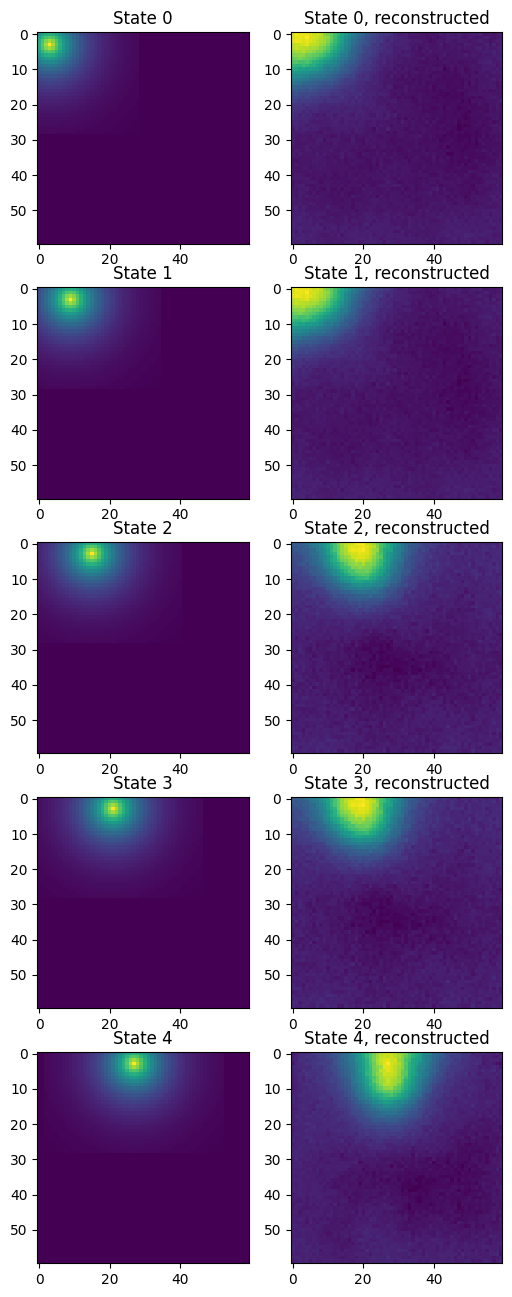

In [17]:
vae_model.eval()
s = np.random.randint(0, EMBEDDING_DIM)
ii = 0
fig, axes = plt.subplots(5, 2, figsize=(6, 16))
for s in range(5):
  X_hat = vae_model(test_data[s,:].view(1, -1).to(DEVICE))

  axes[ii][0].imshow(test_data[s, :].view(map_height, map_height))
  axes[ii][1].imshow(X_hat.view(map_height, map_height).detach().cpu().numpy())
  axes[ii][0].set_title(f'State {ii}')
  axes[ii][1].set_title(f'State {ii}, reconstructed')

  ii+=1



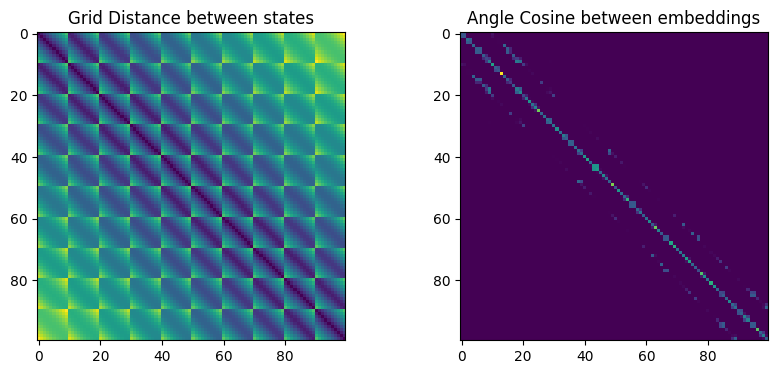

Mean Embedding Similarity: 0.002133570707777872


In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(embedding_eval['Grid Distance'])
axes[1].imshow(embedding_eval['Embedding Angle Cosine'])
axes[0].set_title('Grid Distance between states')
axes[1].set_title('Angle Cosine between embeddings')
plt.show()


embd_dot = embedding_eval['Embedding Angle Cosine']
idx = np.tril(np.ones_like(embd_dot, dtype=bool), k=-1)
print(f"Mean Embedding Similarity: {embd_dot.reshape(-1)[idx.reshape(-1)].mean()}")


# Value Iteration
Now that we have a state-inference model, we want to take the model to do a planning task.  The first step is to generate a new random walk, where rewards are observed (ideally a much shorter walk) and use these to estimate a transition and reward function.  We can then use value iteration, and re-projecte the value function into the original space for visualization.  

Ultimately, we'd like to use a task.  We could implment DYNA-Q on the state space, and then recreate figure 8.2 from Sutton and Barto (second edition, page 165 below) 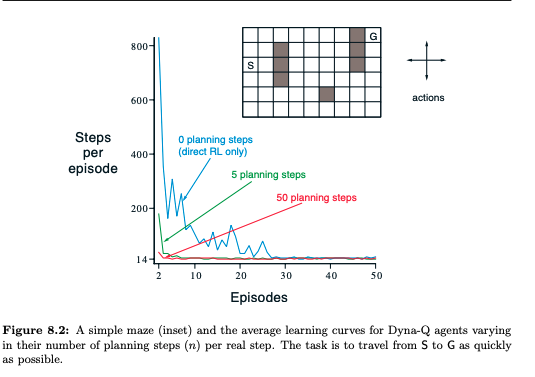

### Transition Function

In [19]:

transitions = make_cardinal_transition_function(h, w)
transitions

{'up': array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'down': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]]),
 'left': array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.]]),
 'right': array([[0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0

## Reward functions

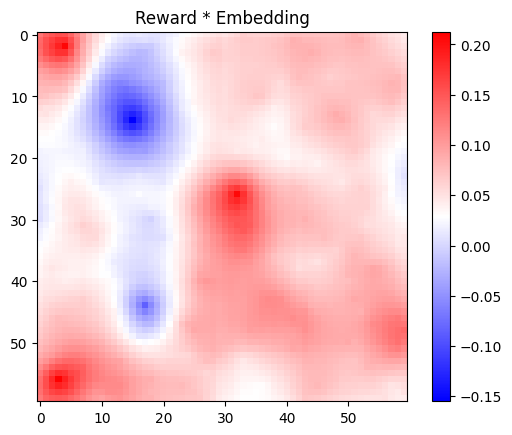

In [20]:
# Pick some interesting reward function
rewards = {
    72: -1,
    22: -1,
    45: +1,
    0: +1,
    90: +1,
}

# for Display purposes, we can show the reward function embedded in the original
# space.  This doesn't have a clean interpretation, but it shows us 
# roughly where pixels are associated with positive or negative reward

reward_map = np.mean(
    [observation_model(s) * r for s, r in rewards.items()], axis=0
).reshape(map_height, -1)

plt.imshow(reward_map, cmap="bwr")
plt.title("Reward * Embedding")
plt.colorbar()
plt.show()


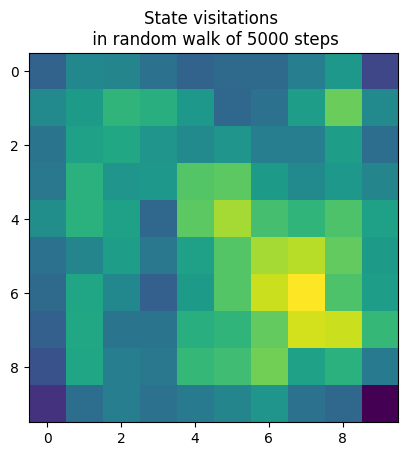

In [21]:
n = 5000
state_counts, walk = generate_random_walk(n, edges)
plt.imshow(state_counts.reshape(grid_size,grid_size))
plt.title(f'State visitations \n in random walk of {n} steps')
plt.show()

# observation_model()
walk_observations = torch.tensor(np.stack([
    observation_model(s).reshape(-1)
    # corrupt_embedding(states[s][0], states[s][1], map_height, kernel).reshape(-1)
    for s in walk
    ]))
walk_rewards = [rewards.get(s, 0) for s in walk]


## Value iteration

In [22]:
walk_states = vae_model.get_state(walk_observations.to(DEVICE)).detach().cpu().numpy()
walk_states = [tuple(s) for s in walk_states]

transition_model = TransitionModel()
transition_model.batch_update(walk_states)

reward_model = RewardModel()
reward_model.batch_update(walk_states, walk_rewards)

In [23]:
q, v = value_iteration(
    {'N': transition_model},
    reward_model,
    gamma=0.80,
    iterations=100
    )

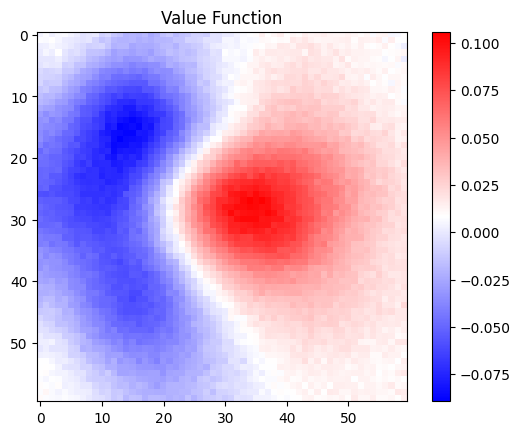

In [24]:
value_function = []
for (s, vs) in v.items():
  x = vae_model.decode_state(s)
  value_function.append(x * vs)

plt.imshow(
    np.array(value_function).squeeze().mean(axis=0).reshape(map_height, -1),
    cmap='bwr'
)

# plt.imshow(reward_map, cmap="bwr")
plt.title("Value Function")
plt.colorbar()
plt.show()

In [ ]:
import time
time.sleep(10)


from google.colab import runtime 
runtime.unassign()